In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import numpy as np
import sys
import os

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../../'))

import utils.ml_util
importlib.reload(utils.ml_util)
from utils.ml_util import *

import utils.trading_util
importlib.reload(utils.trading_util)
from utils.trading_util import *

2025-01-11 20:29:24.362889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736645364.381375   10616 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736645364.386806   10616 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 20:29:24.406482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%***********************]  1 of 1 completed


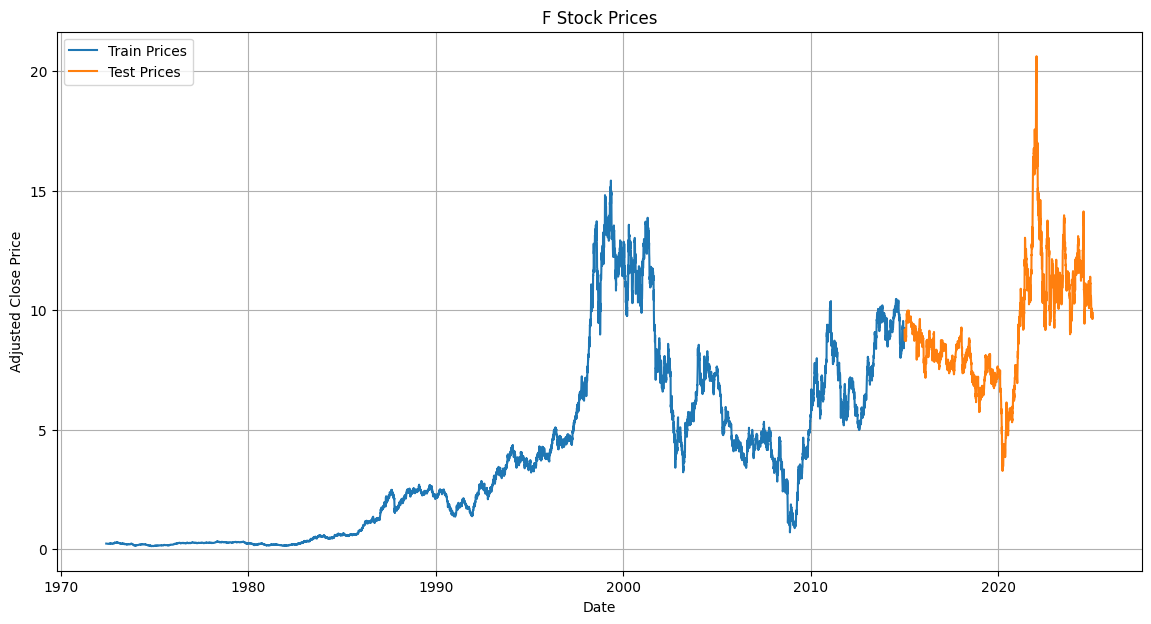

In [2]:
TKR = 'F'
MAX_HOLDING = 100
MAX_HISTORY = 200
FEATURE_KERNEL_SIZES = [5, 10]
TEST_TRAIN_SPLIT = pd.Timestamp('2015-01-01')
TIME_EFFECT = 2

historic_prices = yf.download(TKR)['Close']
train_prices, test_prices = historic_prices[TKR][pd.Timestamp('1990-01-01'):TEST_TRAIN_SPLIT].to_list(), historic_prices[TKR][TEST_TRAIN_SPLIT:].to_list()
plt.figure(figsize=(14, 7))
plt.plot(historic_prices[TKR][:TEST_TRAIN_SPLIT], label='Train Prices')
plt.plot(historic_prices[TKR][TEST_TRAIN_SPLIT:], label='Test Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title(f'{TKR} Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
outlook = []
for pos1 in range(len(train_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (train_prices[pos1 + pos2] - train_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    outlook.append(ans / time_effect_integrals[TIME_EFFECT](MAX_HOLDING))
    
n_outlook = normalize_average(outlook, MAX_HOLDING * 3)

In [4]:
features = get_sma_sd_v(train_prices, FEATURE_KERNEL_SIZES, MAX_HISTORY)[:-MAX_HOLDING - 1]
n_outlook = n_outlook[MAX_HISTORY + max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(features)
x_copy = np.copy(x)
y = np.array(n_outlook)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def create_model():
    inputs = tf.keras.layers.Input(shape=(len(x_train[0]), 1))
    
    x = tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    attention = tf.keras.layers.Attention()([x, x])
    x = tf.keras.layers.Add()([x, attention])
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Conv1D(512, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(512, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='tanh')(x)
    
    return tf.keras.models.Model(inputs, outputs)

def custom_weighted_loss(y_true, y_pred):
    error = y_true - y_pred
    weight = tf.exp(tf.abs(y_true) * 2)
    loss = tf.reduce_mean(weight * tf.square(error))
    return loss

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='mean_absolute_error')
print(model.summary())

W0000 00:00:1736645372.304625   10616 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1200, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1200, 128) │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1200, 128) │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1200, 256) │     98,560 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1200, 256) │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1200, 256) │          0 │ batch_normalizat… │
│ (Attention)         │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1200, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1200, 256) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1200, 512) │    393,728 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1200, 512) │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1200, 512) │    786,944 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1200, 512) │      2,048 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,457,921 (5.56 MB)

 Trainable params: 1,455,105 (5.55 MB)

 Non-trainable params: 2,816 (11.00 KB)

None


In [6]:
model.fit(x=x_train, 
        y=y_train, 
        epochs=30, 
        validation_data=(x_test, y_test), 
    )

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - loss: 0.4165 - val_loss: 0.6207
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - loss: 0.3539 - val_loss: 0.3612
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 576s 4s/step - loss: 0.3491 - val_loss: 0.3931
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 627s 4s/step - loss: 0.3488 - val_loss: 0.3795
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 604s 4s/step - loss: 0.3352 - val_loss: 0.3991
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 583s 4s/step - loss: 0.3349 - val_loss: 0.3331
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - loss: 0.3149 - val_loss: 0.3670
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - loss: 0.2980 - val_loss: 0.2937
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - loss: 0.2959 - val_loss: 0.3656
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - loss: 0.2887 - val_loss: 0.3394
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 581s 4s/step - loss: 0.2803 - val_loss: 0.2892
Epoch 12/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:
features = get_sma_sd_v(test_prices, FEATURE_KERNEL_SIZES, MAX_HISTORY)
test_prices = test_prices[MAX_HISTORY + max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(features)

p_outlook = model.predict(x)
p_outlook = [x[0] for x in p_outlook]

73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step


In [8]:
test_o = []
for pos1 in range(len(test_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (test_prices[pos1 + pos2] - test_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    test_o.append(ans / time_effect_integrals[TIME_EFFECT](MAX_HOLDING))

test_on = normalize_average(test_o, MAX_HOLDING * 3)

err_test = [test_on[pos] - p_outlook[pos] for pos in range(len(test_on))]
train_outlook_p = model.predict(x_copy)
err_train = [train_outlook_p[pos] - y[pos] for pos in range(len(train_outlook_p))]


188/188 ━━━━━━━━━━━━━━━━━━━━ 98s 520ms/step


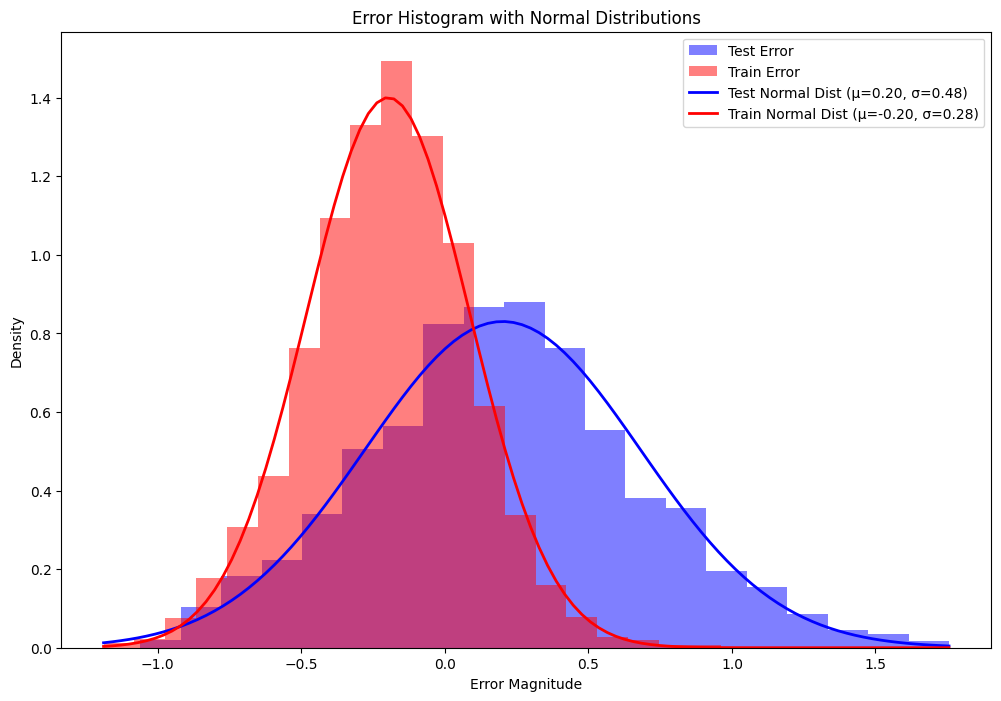

In [9]:
err_test = np.array(err_test)
err_train = np.array(err_train)

mu_test = np.mean(err_test)
std_test = np.std(err_test)
mu_train = np.mean(err_train)
std_train = np.std(err_train)

x = np.linspace(min(err_test.min(), err_train.min()), max(err_test.max(), err_train.max()), 100)
y_test = (1 / (std_test * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_test) / std_test)**2)
y_train = (1 / (std_train * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_train) / std_train)**2)

plt.figure(figsize=(12, 8))
plt.hist(err_test, bins=20, density=True, alpha=0.5, label='Test Error', color='blue')
plt.hist(err_train, bins=20, density=True, alpha=0.5, label='Train Error', color='red')

plt.plot(x, y_test, 'blue', lw=2, label=f'Test Normal Dist (μ={mu_test:.2f}, σ={std_test:.2f})')
plt.plot(x, y_train, 'red', lw=2, label=f'Train Normal Dist (μ={mu_train:.2f}, σ={std_train:.2f})')

plt.title('Error Histogram with Normal Distributions')
plt.xlabel('Error Magnitude')
plt.ylabel('Density')
plt.legend()
plt.show()